# Notebook for my ML prediction on the cleaned dataset

## 1. Create a Baseline to estimate what a good score could be

## 2. Create the models
- Linear Regression
- Ridge Regression 
- Lasso Regression
- Light GB
- XGBoost
- GradientBooster

## 3. Stacked model 

### -----------------------------------------------------------
<br>

#### Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle as pkl

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

# stat
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import reciprocal, uniform

# model hypertuning with optima
import optuna

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore")

# Mean absolute error (MAE)
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

pd.set_option('display.max_rows', 500);

C:\Users\xavier\anaconda3\envs\env_X\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('Ames_prepared.csv')
with open('columns_grouped', 'rb') as f:
    dict_cols = pkl.load(f)

In [3]:
# unpack the values inside the dict and create the lists
k, v = zip(*dict_cols.items())
cols_to_use, cols_ord, cols_dum, cols_bool, target = v[0], v[1], v[2], v[3], v[4]

In [4]:
for col in df.columns:
    if df[col].dtype == object and col not in cols_dum:
        print(col)
        
df.drop('logSalePrice', axis=1, inplace=True) # we will be using the log but with the log func as it will be simpler to reverse

# 1. Create a Baseline 

In [5]:
# lets create a baseline with the two best predictors to see the score

X_bas, y = df[['TotalSF', 'OverallQual']].values, df.SalePrice.values
X_bas_tr, X_bas_te, y_tr, y_te = train_test_split(X_bas, y, test_size=0.3, random_state=0)

lr = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp)
lr.fit(X_bas_tr, y_tr)

print(f'Baseline score with {lr.score(X_bas_te, y_te):.2%} and a mean prediction of {MAE(y_te, lr.predict(X_bas_te)):.2f} $')

Baseline score with 86.73% and a mean prediction of 21540.65 $


# 2. Lets create the models

I created most of my models and hypertuned them with GridSearchCV from Sklearn but for the lgbm, xgb and gb Gridsearch was simply too long and the improvement on the model was almost inexistant. After searching for other tools I found optima which is works perfectly and is an amazing gain of time for tuning models.

I first wanted to try and see if there is a difference working with a pipeline or transformed dataset, apparently there is (here 296.815 on the MAE which is weirdly huge, if anyone spot a mistake i'll gladly correct it).


In [6]:
# Pipeline model:
X, y = df.drop('SalePrice', axis=1), df.SalePrice.values
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=0) # --> te used ONLY for last check (thats why I chose a to remove a small 0.2 test set)
print(f'Shape of our train dataset: {X_tr.shape}')

# Create the column transformer
preprocessor = ColumnTransformer([
    ('nominal', OneHotEncoder(drop='first', handle_unknown='ignore'), cols_dum),
    ], remainder='passthrough')

# Create Pipeline
pipe_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', RobustScaler(with_centering=False)),
    ('regressor', TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp))
])

pipe_1.fit(X_tr, y_tr)

score_p = MAE(y_te, pipe_1.predict(X_te))
score_p_ = pipe_1.score(X_te, y_te)

# ------------------------------------
# Without Pipe

# get dummies in the dataset
df_dums = pd.get_dummies(df, columns=cols_dum, drop_first=True)
X, y = df_dums.drop('SalePrice', axis=1), df_dums.SalePrice.values
# scale X
robscaler = RobustScaler()
X = robscaler.fit_transform(X)

# log y
y = np.log1p(y)
X_tr_, X_te_, y_tr_, y_te_ = train_test_split(X, y, test_size=0.2, random_state=0)
print(f'Shape of our train dataset: {X_tr_.shape}')
# create and fit LR
lr = LinearRegression()
lr.fit(X_tr_, y_tr_)

score_lr = MAE(np.expm1(y_te_), np.expm1(lr.predict(X_te_)))
score_lr_ = lr.score(X_te_, y_te_)
              
print(f'LR with pipe give us MAE: {score_p:.2f} $ and LR without pipe gives us MAE: {score_lr:.2f} $, a difference of {score_lr - score_p:.3f}')
# I'll be working with the pipeline

Shape of our train dataset: (2284, 67)
Shape of our train dataset: (2284, 225)
LR with pipe give us MAE: 12739.19 $ and LR without pipe gives us MAE: 13036.00 $, a difference of 296.815


## 2. Train test separation


In [7]:
# these will always be used for all models now (regression)
X, y = df.drop('SalePrice', axis=1), df.SalePrice.values
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=0) 

print(f'We have {X_tr.shape[0]} rows and {X_tr.shape[1]} features in the train set')
print(f'We have {X_te.shape[0]} rows and {X_te.shape[1]} features in the test set')

def grid_model(model, grid):
    
    # Create the column transformer
    preprocessor = ColumnTransformer([
        ('nominal', OneHotEncoder(drop='first', handle_unknown='ignore'), cols_dum),
        ], remainder='passthrough')

    # Create Pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', RobustScaler(with_centering=False)),
        ('regressor', TransformedTargetRegressor(regressor=model, func=np.log, inverse_func=np.exp))
    ])

    grid_cv = GridSearchCV(pipe, grid, cv=5, return_train_score=True, n_jobs=-1, verbose=2)
    grid_cv.fit(X_tr, y_tr);

    print(f'The pipeline predicts our target with a {grid_cv.score(X_te, y_te):.2%} accuracy and a MAE of {MAE(y_te, grid_cv.predict(X_te)):.2f} $ on the test set')    
    return grid_cv

def plot_model(grid_search, param):
    # Collect results in a DataFrame
    cv_results = pd.DataFrame(grid_search.cv_results_)
    # Group results by alpha value
    grouped = cv_results.groupby('param_regressor__regressor__' + param).mean()
    # Plot mean scores
    plt.plot(grouped.index, grouped.mean_train_score, label='train')
    plt.plot(grouped.index, grouped.mean_test_score, label='test')
    # Add marker for best score
    best_estimator = grouped.mean_test_score.idxmax()
    plt.scatter(best_estimator, grouped.mean_test_score.max(), marker='x', c='red', zorder=10)
    # Quantify variance with ±std curves
    plt.fill_between(grouped.index, grouped.mean_train_score-grouped.std_train_score, grouped.mean_train_score+grouped.std_train_score, alpha=0.2)
    plt.fill_between(grouped.index, grouped.mean_test_score-grouped.std_test_score, grouped.mean_test_score+grouped.std_test_score, alpha=0.2)
    plt.title('Best estimator: {} with {:.1f}% accuracy'.format(best_estimator, 100*grouped.mean_test_score[best_estimator]))
    plt.ylabel('accuracy')
    plt.xlabel(param)
    plt.legend()
    plt.show()
    return cv_results

scores_dict = {}

We have 2284 rows and 67 features in the train set
We have 571 rows and 67 features in the test set


## LinearRegression 

In [8]:
# Linear Regression
grid_li = {}
grid_linear = grid_model(LinearRegression(), grid_li)

scores_dict['linear'] = MAE(y_te, grid_linear.predict(X_te))

print(f'best estimator is: {grid_linear.best_estimator_.named_steps.regressor}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
The pipeline predicts our target with a 94.93% accuracy and a MAE of 12739.19 $ on the test set
best estimator is: TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())


## Ridge Regression



Fitting 5 folds for each of 200 candidates, totalling 1000 fits
The pipeline predicts our target with a 95.39% accuracy and a MAE of 12645.83 $ on the test set


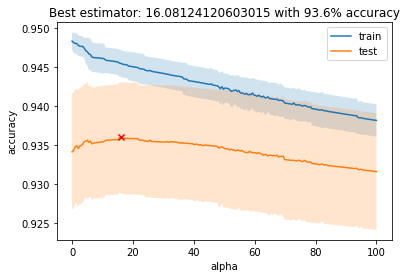

best estimator is: TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Ridge(alpha=16.08124120603015))


In [9]:
## Ridge Regression
grid_r = {'regressor__regressor__alpha':np.linspace(0.001, 100, 200)}
grid_ridge = grid_model(Ridge(), grid_r)

scores_dict['ridge'] = MAE(y_te, grid_ridge.predict(X_te))

cv_results_ri = plot_model(grid_ridge, 'alpha')
print(f'best estimator is: {grid_ridge.best_estimator_.named_steps.regressor}')

## Lasso Regression

Fitting 5 folds for each of 100 candidates, totalling 500 fits
The pipeline predicts our target with a 95.52% accuracy and a MAE of 12337.49 $ on the test set


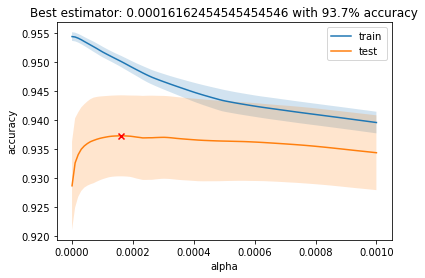

best estimator is: TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Lasso(alpha=0.00016162454545454546,
                                           max_iter=100000))


In [10]:
grid_l = {'regressor__regressor__alpha':np.linspace(10e-9, 0.001, 100),
         'regressor__regressor__max_iter': [100_000]}
grid_lasso = grid_model(Lasso(), grid_l)

scores_dict['lasso'] = MAE(y_te, grid_lasso.predict(X_te))

cv_results_la = plot_model(grid_lasso, 'alpha')

print(f'best estimator is: {grid_lasso.best_estimator_.named_steps.regressor}')

## Light LGB

In [11]:
# realise a hyperparams tuning with optuna!
# # https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
# Never used Optuna before and its a real gain of time to tune !!

def objective(trial):
    
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000, step=10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "num_leaves": trial.suggest_int("num_leaves", 5, 300, step=5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 100, step=1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.01),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.01),
        #"max_bin": trial.suggest_int("max_bin", 30, 70, step=1),
    }
    
        # Create the column transformer
    preprocessor = ColumnTransformer([
        ('nominal', OneHotEncoder(drop='first', handle_unknown='ignore'), cols_dum),
        ], remainder='passthrough')

    # Create Pipeline
    pipe_lgb = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', RobustScaler(with_centering=False)),
        ('regressor', TransformedTargetRegressor(
            regressor=lgb.LGBMRegressor(**param_grid, feature_fraction_seed=14, bagging_seed=14)
            , func=np.log, inverse_func=np.exp))
    ])

    pipe_lgb.fit(X_tr, y_tr)
    y_pred = pipe_lgb.predict(X_te)
    mae = MAE(y_te, y_pred)
    print(f"Model MAE: {round(mae, 6)}")
    return mae # return our objective value

# if __name__ == "__main__":
#     study = optuna.create_study(
#         sampler=optuna.samplers.TPESampler()
#     )
#     study.optimize(objective, n_trials=300)

#     print("Number of finished trials: {}".format(len(study.trials)))

#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))

#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

In [12]:
# fine tuned model:
model_lgb = lgb.LGBMRegressor(objective='regression',
                              n_estimators=950,
                              learning_rate=0.02407009717957826,
                              num_leaves=20,
                              min_data_in_leaf=2,
                              bagging_fraction= 0.35,
                              bagging_freq = 1, 
                              feature_fraction = 0.9199999999999999,
                              feature_fraction_seed=14, bagging_seed=14)

# Create the column transformer
preprocessor = ColumnTransformer([
    ('nominal', OneHotEncoder(drop='first', handle_unknown='ignore'), cols_dum),
    ], remainder='passthrough')

# Create Pipeline
pipe_lgb = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', RobustScaler(with_centering=False)),
    ('regressor', TransformedTargetRegressor(
        regressor=model_lgb, func=np.log, inverse_func=np.exp))
])

pipe_lgb.fit(X_tr, y_tr)

scores_dict['lgbm'] = MAE(y_te, pipe_lgb.predict(X_te))

print(f'The pipeline predicts our target with a {pipe_lgb.score(X_te, y_te):.2%} accuracy and a MAE of {MAE(y_te, pipe_lgb.predict(X_te)):.2f} $ on the test set')

[LightGBM] [Warning] feature_fraction is set=0.9199999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9199999999999999
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.35, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
The pipeline predicts our target with a 95.90% accuracy and a MAE of 11385.82 $ on the test set


# XGBoost 

In [13]:

def objective_xgb(trial):
    
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 5000, step=20),
        "max_depth": trial.suggest_int("max_depth", 1, 30, step=2),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 0.95),
        "gamma": trial.suggest_float("gamma", 0.001, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 1),
        #"max_bin": trial.suggest_int("max_bin", 30, 70, step=1),
    }
    
    # Create the column transformer
    preprocessor = ColumnTransformer([
        ('nominal', OneHotEncoder(drop='first', handle_unknown='ignore'), cols_dum),
        ], remainder='passthrough')

    # Create Pipeline
    pipe_xgb = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', RobustScaler(with_centering=False)),
        ('regressor', TransformedTargetRegressor(
            regressor=xgb.XGBRegressor(**param_grid, random_state=14)
            , func=np.log, inverse_func=np.exp))
    ])

    pipe_xgb.fit(X_tr, y_tr)
    y_pred = pipe_xgb.predict(X_te)
    mae = MAE(y_te, y_pred)
    print(f"Model MAE: {round(mae, 6)}")
    return mae # return our objective value


# if __name__ == "__main__":
#     study_xgb = optuna.create_study(
#         sampler=optuna.samplers.TPESampler()
#     )
#     study_xgb.optimize(objective_xgb, n_trials=100)

#     print("Number of finished trials: {}".format(len(study_xgb.trials)))

#     print("Best trial:")
#     trial = study_xgb.best_trial

#     print("  Value: {}".format(trial.value))

#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

In [14]:
# {'n_estimators': 2180, 'max_depth': 9, 'learning_rate': 0.042132322085510786, 'colsample_bytree': 0.21082651543070063, 
# 'gamma': 0.0056211195829035665, 'reg_alpha': 0.4818050113004029, 'reg_lambda': 0.6391073956653768}

model_xgb = xgb.XGBRegressor(n_estimators=2180,
                             max_depth= 9,
                             learning_rate = 0.042132322085510786, 
                             colsample_bytree = 0.21082651543070063, 
                             gamma = 0.0056211195829035665, 
                             reg_alpha = 0.4818050113004029, 
                             reg_lambda = 0.6391073956653768,
                             random_state=14, 
                             )

# Create the column transformer
preprocessor = ColumnTransformer([
    ('nominal', OneHotEncoder(drop='first', handle_unknown='ignore'), cols_dum),
    ], remainder='passthrough')

# Create Pipeline
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', RobustScaler(with_centering=False)),
    ('regressor', TransformedTargetRegressor(
        regressor=model_xgb, func=np.log, inverse_func=np.exp))
])

pipe_xgb.fit(X_tr, y_tr)

scores_dict['xgboost'] = MAE(y_te, pipe_xgb.predict(X_te))

print(f'The pipeline predicts our target with a {pipe_xgb.score(X_te, y_te):.2%} accuracy and a MAE of {MAE(y_te, pipe_xgb.predict(X_te)):.2f} $ on the test set')

The pipeline predicts our target with a 94.94% accuracy and a MAE of 12247.69 $ on the test set


# GBoost

In [15]:
def objective_gb(trial):
    
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 7000, step=20),
        "max_depth": trial.suggest_int("max_depth", 1, 20, step=2),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50, step=1)
    }
    
        # Create the column transformer
    preprocessor = ColumnTransformer([
        ('nominal', OneHotEncoder(drop='first', handle_unknown='ignore'), cols_dum),
        ], remainder='passthrough')

    # Create Pipeline
    pipe_gb = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', RobustScaler(with_centering=False)),
        ('regressor', TransformedTargetRegressor(
            regressor=GradientBoostingRegressor(**param_grid, loss='huber', max_features='sqrt', random_state=14)
            , func=np.log, inverse_func=np.exp))
    ])

    pipe_gb.fit(X_tr, y_tr)
    y_pred = pipe_gb.predict(X_te)
    mae = MAE(y_te, y_pred)
    print(f"Model MAE: {round(mae, 6)}")
    return mae # return our objective value


# if __name__ == "__main__":
#     study_gb = optuna.create_study(
#         sampler=optuna.samplers.TPESampler()
#     )
#     study_gb.optimize(objective_gb, n_trials=50)

#     print("Number of finished trials: {}".format(len(study_gb.trials)))

#     print("Best trial:")
#     trial = study_gb.best_trial

#     print("  Value: {}".format(trial.value))

#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

In [16]:
# params={'n_estimators': 4080, 'max_depth': 5, 'learning_rate': 0.022995922215616475, 'min_samples_split': 39}
GBoost = GradientBoostingRegressor(n_estimators=4080, 
                                   learning_rate=0.022995922215616475,
                                   max_depth=5, 
                                   max_features='sqrt',
                                   # min_samples_leaf=15, 
                                   min_samples_split=39, 
                                   loss='huber', 
                                   random_state =14)

# Create the column transformer
preprocessor = ColumnTransformer([
    ('nominal', OneHotEncoder(drop='first', handle_unknown='ignore'), cols_dum),
    ], remainder='passthrough')

# Create Pipeline
pipe_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', RobustScaler(with_centering=False)),
    ('regressor', TransformedTargetRegressor(
        regressor=GBoost, func=np.log, inverse_func=np.exp))
])

pipe_gb.fit(X_tr, y_tr)

scores_dict['gboost'] = MAE(y_te, pipe_gb.predict(X_te))

print(f'The pipeline predicts our target with a {pipe_gb.score(X_te, y_te):.2%} accuracy and a MAE of {MAE(y_te, pipe_gb.predict(X_te)):.2f} $ on the test set')

The pipeline predicts our target with a 95.81% accuracy and a MAE of 11483.93 $ on the test set


# Best model : LGBM

Our best model is the LightGBM with 11385$.

Our score is very good, even if our datasets are small and the predictions are made on 20% (our model would most probably lose some of its efficiency if it had to predict 40-50% of the data). 
I adapted this notebook to try to see my score on Kaggle in the ['House Price'](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) competition and managed to predict with a RMSE of 0.12243.

I'm more than happy with my score which is in the top 9% of the leaderboard.

It was in this competition that I was able to learn to stack my models for more robust predictions. I try below to create such a model just to learn this very useful skill.

--> To play with the robustness of my model I fit the models on 60% of the data and try to predict 40% which should be a good test to see how well the model performs.

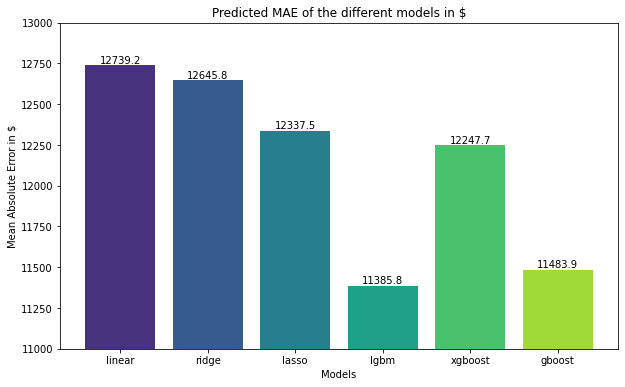

In [20]:
mods, vals = zip(*scores_dict.items())
palette = sns.color_palette('viridis', len(mods))

f,ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(mods, vals, color=palette)
ax.bar_label(bars)

plt.title('Predicted MAE of the different models in $')
plt.ylabel('Mean Absolute Error in $')
plt.xlabel('Models')
plt.ylim(11000, 13000)
plt.show();

# Trying to stack the models 


In [21]:
# try the stacked model
# I need a different kind of pipeline 

X_dum = pd.get_dummies(df, columns=cols_dum, drop_first=True)
X_dum, y = X_dum.drop('SalePrice', axis=1), X_dum.SalePrice.values
X_tr, X_te, y_tr, y_te = train_test_split(X_dum, np.log1p(y), test_size=0.4, random_state=0) 

ridge = make_pipeline(RobustScaler(), Ridge(alpha=16.08124120603015))
ridge.fit(X_tr, y_tr);

lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.00016162454545454546))
lasso.fit(X_tr, y_tr);

model_lgbm = make_pipeline(RobustScaler(), lgb.LGBMRegressor(objective='regression',
                              n_estimators=950,
                              learning_rate=0.02407009717957826,
                              num_leaves=20,
                              min_data_in_leaf=2,
                              bagging_fraction= 0.35,
                              bagging_freq = 1, 
                              feature_fraction = 0.9199999999999999,
                              feature_fraction_seed=14, bagging_seed=14))
model_lgbm.fit(X_tr, y_tr)

model_xgboost = make_pipeline(RobustScaler(), xgb.XGBRegressor(n_estimators=2180,
                             max_depth= 9,
                             learning_rate = 0.042132322085510786, 
                             colsample_bytree = 0.21082651543070063, 
                             gamma = 0.0056211195829035665, 
                             reg_alpha = 0.4818050113004029, 
                             reg_lambda = 0.6391073956653768,
                             random_state=14, 
                             ))
model_xgboost.fit(X_tr, y_tr)

model_gb = make_pipeline(RobustScaler(), GradientBoostingRegressor(n_estimators=4080, 
                                   learning_rate=0.022995922215616475,
                                   max_depth=5, 
                                   max_features='sqrt',
                                   # min_samples_leaf=15, 
                                   min_samples_split=39, 
                                   loss='huber', 
                                   random_state =14))
model_gb.fit(X_tr, y_tr);

[LightGBM] [Warning] feature_fraction is set=0.9199999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9199999999999999
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.35, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [22]:
# https://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/
from mlxtend.regressor import StackingCVRegressor

# Stack up all the models above, optimized using xgboost
stacked_model = StackingCVRegressor(regressors=(ridge, lasso, model_lgbm, model_xgboost, model_gb),
                                meta_regressor=model_lgbm,
                                use_features_in_secondary=True,
                                random_state =0)

stacked_model.fit(X_tr, y_tr);

print(f'The stacked model predictions gives us a MAE of {MAE(np.expm1(y_te), np.expm1(stacked_model.predict(X_te))):.2f} $ on the test set')

[LightGBM] [Warning] feature_fraction is set=0.9199999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9199999999999999
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.35, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9199999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9199999999999999
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.35, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=

In [23]:
# stacked with blend model

def blended_predictions(X):
    return ((0.1 * ridge.predict(X)) + \
            (0.1 * lasso.predict(X)) + \
            (0.3 * model_lgbm.predict(X)) + \
            (0.1 * model_xgboost.predict(X)) + \
            (0.2 * model_gb.predict(X)) + \
            (0.2 * stacked_model.predict(X)))

print(f'The LGBM model gives us a MAE of {MAE(np.expm1(y_te), np.expm1(model_lgbm.predict(X_te))):.2f} $ on the test set')
print(f'The blend prediction gives us a MAE of {MAE(np.expm1(y_te), np.floor(np.expm1(blended_predictions(X_te)))):.2f} $ on the test set')

The LGBM model gives us a MAE of 13218.42 $ on the test set
The blend prediction gives us a MAE of 12385.41 $ on the test set
